In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns; sns.set()

In [2]:
from collections import Counter

In [3]:
# for the purpose of emotions sense/direction analysis
from extractEmotions import emotionalDirection

## Functions for analysis

#### Create a directory for storing plots

In [4]:
# global variable for storage directory (to be accessed by any function)
storage_directory = "emotions__reports_plots"
if not os.path.isdir(storage_directory):
    os.mkdir(storage_directory)

In [5]:
def plotIntensity(emotions_intensity, save_name):
    plt.figure(figsize=(10,10))
    emotions_intensity.plot(kind="kde")
    plt.title("Emotions embedded in tweets")
    plt.xlabel("Emotions sense")
    plt.savefig(f"{storage_directory}/{save_name}")
    plt.show()

In [6]:
def generalEmotionsCount(dataframe, emotions_columns, save=False):
    dominant_emotions_tweets = []
    emotion = []
    for column in emotions_columns:
        # extract the tweets in which the emotion's probability is higher than 50%
        # this allows to capture the dominant emotion
        # append those to a list
        dominant_emotions_tweets.append(len(dataframe[dataframe[column] > 0.5]) / len(dataframe))
        # append the column name to know which emotions is that
        emotion.append(column)
    # the output is a transposed dataframe
    output_df = pd.DataFrame([emotion, dominant_emotions_tweets]).T
    output_df.columns = ["dominant_emotion", "fraction_of_tweets"]
    # possibility to save it in the "data" directory
    if save:
        if ~(os.path.isdir("data")):
            os.mkdir("data")
        output_df.to_csv("data/general_overview_of_dominant_emotions.csv")
    return output_df

In [7]:
def plotDominantEmotions(dataframe):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x="dominant_emotion", y="fraction_of_tweets", data=emotions_fractions_df)
    plt.xlabel("Dominant Emotions")
    plt.ylabel("Fraction of Tweets")
    plt.title("Emotions which probability exceeded 50% in tweets")
    plt.savefig(f"{storage_directory}/tweets_unambiguous_emotions_shares.png")
    plt.show()

In [8]:
def plotIndividualEmotion(emotion):
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x="dominant_party", y=emotion)
    plt.title(emotion)
    plt.xlabel("Dominant Party")
    plt.ylabel("Fraction")
    plt.savefig(f"{storage_directory}/{emotion}_dominant_parties.png")
    plt.show()

## Loading the dataset

In [9]:
df = pd.read_csv("data/tweets_emotions_dataset.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)

## Studying emotions intensity

In [10]:
df = df.assign(adjusted_intensity = emotionalDirection(df, joy_weight=10, 
                                 sadness_weight=-1, 
                                 anger_weight=-10, 
                                 disgust_weight=-10, 
                                 surprise_weight=-5, 
                                 fear_weight=-5, 
                                 others_weight=0))

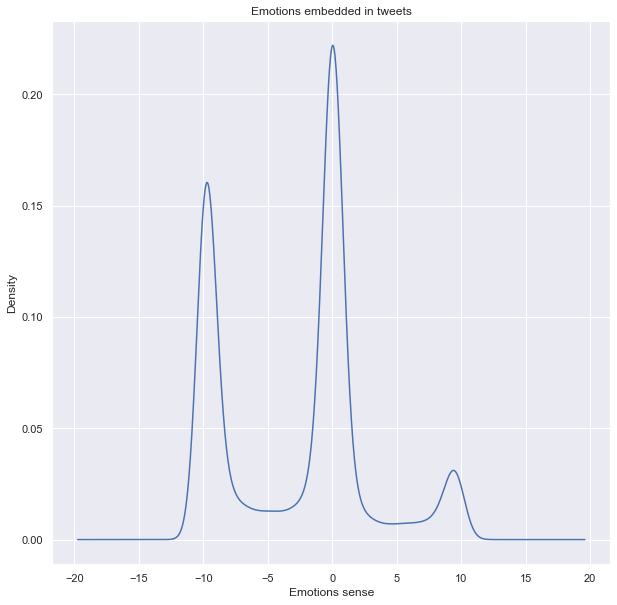

In [11]:
plotIntensity(df["intensity"], "emotions_intensities_and_sense_1.png")

### Including the analysis of fear and surprise 
10 times lower weights, fear and surpirse have the same weight as sadness

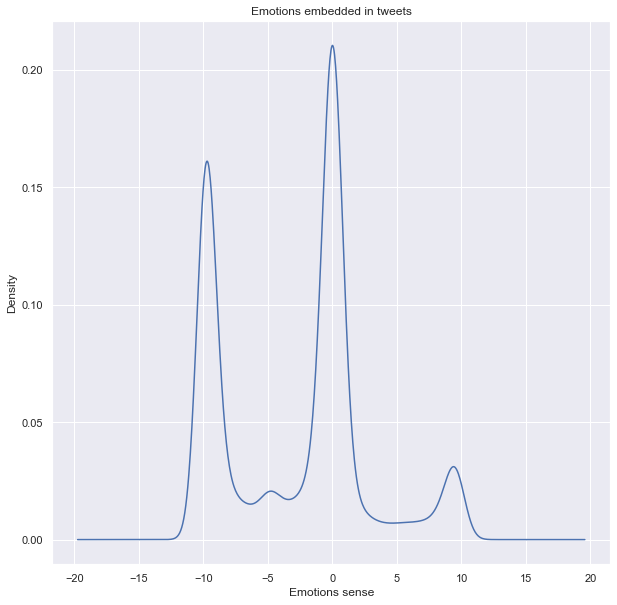

In [12]:
plotIntensity(emotionalDirection(df, joy_weight=10, 
                                 sadness_weight=-1, 
                                 anger_weight=-10, 
                                 disgust_weight=-10, 
                                 surprise_weight=-5, 
                                 fear_weight=-5, 
                                 others_weight=0), "emotions_intensities_and_sense_2.png")

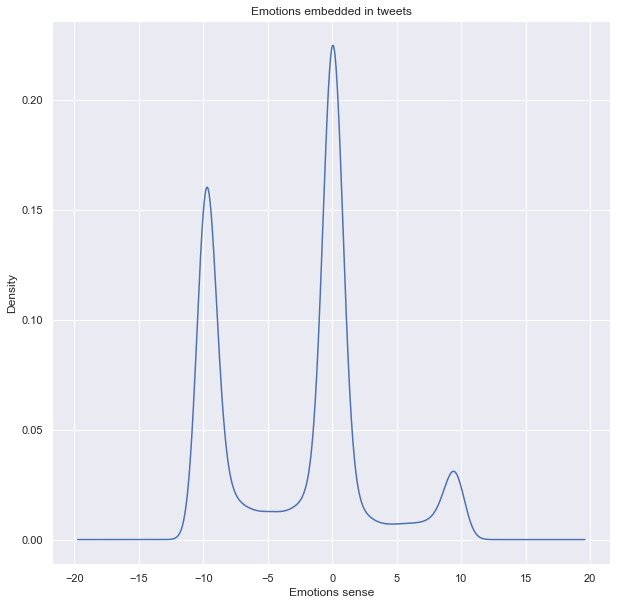

In [13]:
plotIntensity(emotionalDirection(df, joy_weight=10, 
                                 sadness_weight=0, 
                                 anger_weight=-10, 
                                 disgust_weight=-10, 
                                 surprise_weight=0, 
                                 fear_weight=0, 
                                 others_weight=0), "emotions_intensities_and_sense_3.png")

As seen above, assigning moderately negative weights to fear and surprise, they became visible as a hill between neutral and negative emotions. 

It is quite evident that the majority of tweets can be perceived as neutral message. There are 2 more major hills in these plots - on the left hand side, the *negative*, hateful tweets which are characterized by high scores for anger, disgust or both. On the right hand side, the *positive* tweets, those for which the model yielded high *joy* probabilities.

Unfortunately, these results suggest that apart from a mixture of emotions or neutrality visualized as the major hill near 0, the tweets are characterized by dominant *negative* emotions in this political debate. 

## Dominant Emotions

Emotions for which the probability yielded by model exceeded 50%. The plot presents the fraction of tweets which met this condition. In short, these are the tweets evidently neutral / joyful / sad / fearful / surprised / angry or disgusted.

In [14]:
emotions_fractions_df = generalEmotionsCount(df, ["others", "joy", "sadness", "fear", "surprise", "anger", "disgust"])

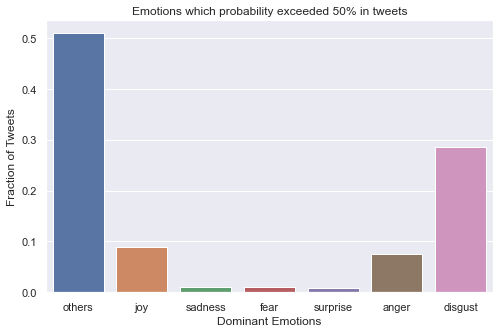

In [15]:
plotDominantEmotions(emotions_fractions_df)

This analysis seems to confirm the correctness of the results obtained in the section above.

## Emotions in states

### Average emotions intensity for states

In [16]:
intensity_mean = pd.DataFrame(df.groupby("state")["adjusted_intensity"].apply(np.mean))

The most negative average intensity of emotions

In [17]:
intensity_mean.sort_values("adjusted_intensity")[:10]

,adjusted_intensity
state,
Hawaii,-6.011667
Vermont,-5.672299
Idaho,-4.513724
Oklahoma,-4.390570
Arkansas,-4.287065
South Carolina,-4.182765
Kentucky,-4.009637
Montana,-3.851416
North Dakota,-3.730624


The most positive average intensity of emotions

In [18]:
intensity_mean.sort_values("adjusted_intensity").tail(10)

,adjusted_intensity
state,
New Hampshire,-1.899630
Massachusetts,-1.751998
Connecticut,-1.632419
Washington,-1.585642
South Dakota,-1.567175
Colorado,-1.458360
Maine,-1.332020
Maryland,-1.036914
New Mexico,-0.756843


### States: standard deviation for emotions intensities

In [19]:
intensity_std = pd.DataFrame(df.groupby("state")["adjusted_intensity"].apply(np.std))

#### 10 states in which the distribution of emotions intensity is closest to the mean 

In [20]:
intensity_std.sort_values("adjusted_intensity")[:10]

,adjusted_intensity
state,
Vermont,4.055051
Rhode Island,4.769727
New Jersey,5.138064
Alaska,5.145288
Massachusetts,5.236441
Florida,5.261799
Maine,5.300908
Hawaii,5.346038
Montana,5.357127


#### 10 states in which the distribution of emotions is scattered further from the mean

In [21]:
intensity_std.sort_values("adjusted_intensity")[-10:]

,adjusted_intensity
state,
Connecticut,5.916826
Kansas,5.925963
Mississippi,5.992312
Wisconsin,5.996809
Washington,6.031400
North Dakota,6.120476
Michigan,6.189021
Iowa,6.258841
South Dakota,6.332390


### How far are the emotion intensities from the mean: skewness

In [22]:
intensity_std.median()

adjusted_intensity    5.678326
dtype: float64

In [23]:
intensity_std.mean()

adjusted_intensity    5.647374
dtype: float64

As seen above, the distribution of the scatter around the mean among the emotions grouped by states is quite symmetrical

## The emotions with the biggest fraction for states

Below, the mean likelihood for each emotion is analyzed for each state. In this context, the probabilities returned by the model's predict() method should be seen as weights - how angry the tweet seems to be? Or how happy it is - based on what the model has learnt about *typical* happiness embedded in tweets. 

In [24]:
df.groupby("state")[["joy","sadness","anger","surprise","disgust","fear"]].mean().idxmax(axis=1)

state
Alabama           disgust
Alaska            disgust
Arizona           disgust
Arkansas          disgust
California        disgust
Colorado          disgust
Connecticut       disgust
Delaware              joy
Florida           disgust
Georgia           disgust
Hawaii            disgust
Idaho             disgust
Illinois          disgust
Iowa              disgust
Kansas            disgust
Kentucky          disgust
Louisiana         disgust
Maine               anger
Maryland          disgust
Massachusetts     disgust
Michigan          disgust
Minnesota         disgust
Mississippi       disgust
Missouri          disgust
Montana           disgust
Nebraska          disgust
Nevada            disgust
New Hampshire     disgust
New Jersey        disgust
New Mexico            joy
New York          disgust
North Carolina    disgust
North Dakota      disgust
Ohio              disgust
Oklahoma          disgust
Oregon            disgust
Pennsylvania      disgust
Rhode Island      disgust
South 

As can be seen, the most common nominal value is disgust

Only 3 states have different average dominant emotions than disgust - these are joy and anger.

# Emotions grouped by party dominance

#### Mean emotions intensity for states grouped by the dominant party

In [25]:
mean_intensities = pd.DataFrame(df.groupby("dominant_party")["adjusted_intensity"].apply(np.mean))
democrats_mean = mean_intensities.iloc[0][0]
republicans_mean = mean_intensities.iloc[1][0]
swing_mean = mean_intensities.iloc[0][0]
mean_intensities

,adjusted_intensity
dominant_party,
democrat,-2.389208
republican,-3.492878
swing,-2.535952


#### Median for emotions intensity for states grouped by the dominant party

In [26]:
median_intensities = pd.DataFrame(df.groupby("dominant_party")["adjusted_intensity"].apply(np.median))
democrats_median = median_intensities.iloc[0][0]
republicans_median = median_intensities.iloc[1][0]
swing_median = median_intensities.iloc[0][0]
median_intensities

,adjusted_intensity
dominant_party,
democrat,-0.214441
republican,-1.603639
swing,-0.224368


It seems like all of the distributions are negatively skewed, usually the intensities have higher scores than the mean score. There may be a negative score on average, but the majority of people tend to express more positive emotions which are reflected by their intensities. This is mostly due to *neutral* emotions being the dominant intensity.

We can see that especially for swing and democrat groups of states for which the emotions intensities are close to 0. For republican group of states, we can see that the majority of tweets still have a bit more positive emotion intinsity than the average for this group of states, however, they tend to be more negative than the tweets from democrat or swing states.

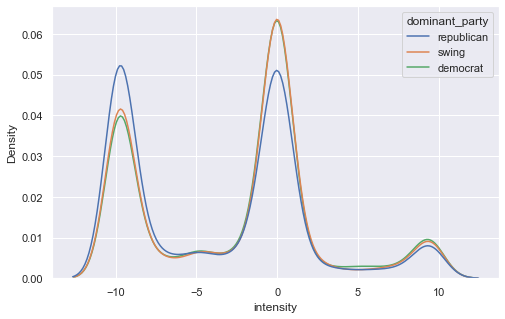

In [27]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="adjusted_intensity", hue="dominant_party",)
plt.xlabel("intensity")
plt.savefig(f"{storage_directory}/intensities_dominant_parties.png")
plt.show()

The kernel density estimation plot above visualized the common pattern for all groups of states.

In [28]:
def plotIntensityDistribution(dominant_p, mean_p, median_p, color_hue):
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df[df.dominant_party == dominant_p], x="adjusted_intensity", color=color_hue)
    plt.axvline(mean_p, color="orange", linestyle='--')
    plt.axvline(median_p, color="olive", linestyle='--')
    plt.xlabel("intensity")
    plt.savefig(f"{storage_directory}/{dominant_p}_emotions_intensities.png")
    plt.show()

## Emotions intensities' distributions

The data **mean** is shown as a ORANGE dashed line, the **median** is shown as a OLIVE dashed line

### Republican

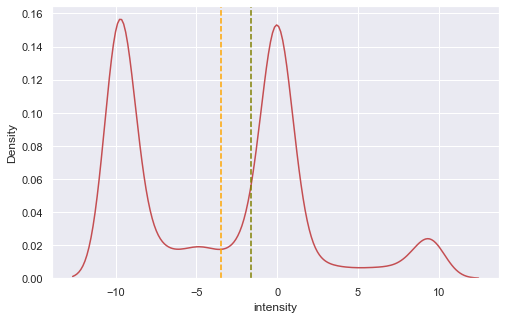

In [29]:
plotIntensityDistribution("republican", republicans_mean, republicans_median, "r")

### Democrat

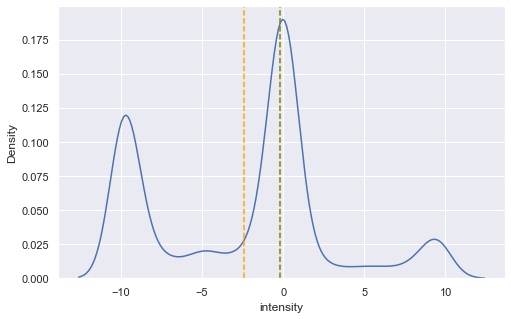

In [30]:
plotIntensityDistribution("democrat", democrats_mean, democrats_median, "b")

### Swing

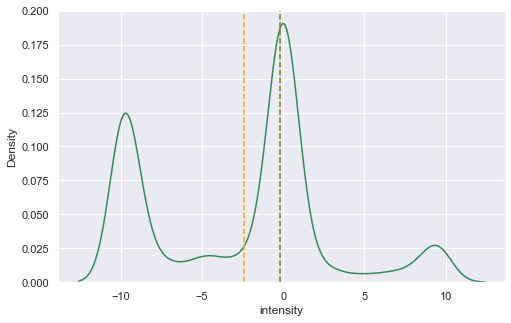

In [31]:
plotIntensityDistribution("swing", swing_mean, swing_median, "seagreen")

All the distributions are characterized by a smaller mean than median. This indicates a negative skewness of the data distribution. All of the states groups have a similar pattern. The most similar ditributions are those for democrat and swing states. 

## Individual emotions analysis by state groups

### Joy

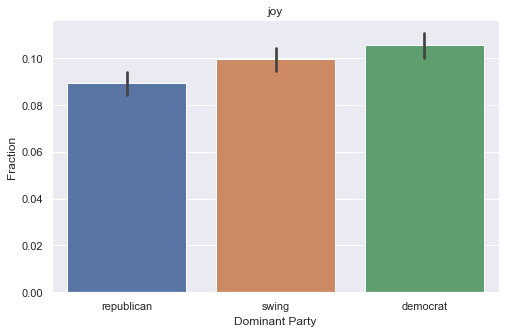

In [32]:
plotIndividualEmotion("joy")

Similar: swing and democrat

### Sadness

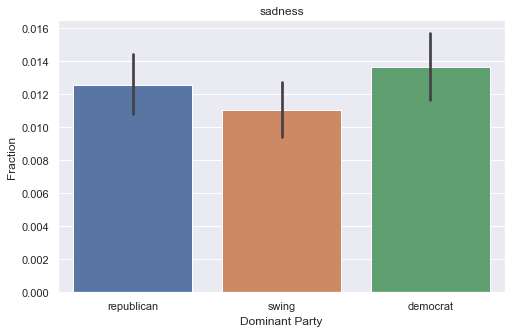

In [33]:
plotIndividualEmotion("sadness")

Similar: republican and democrat

### Anger

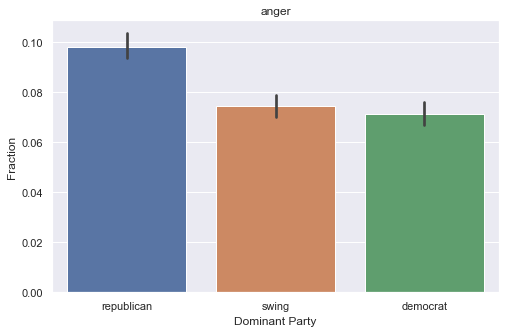

In [34]:
plotIndividualEmotion("anger")

Similar: swing and democrat

### Fear

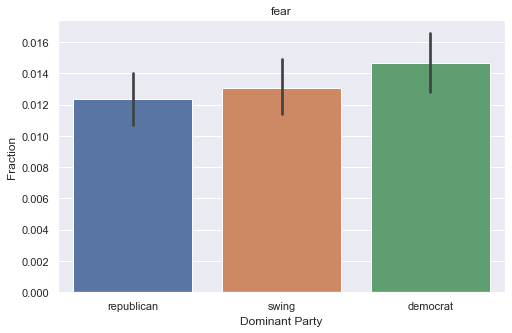

In [35]:
plotIndividualEmotion("fear")

Similar: swing and democrat

### Surprise

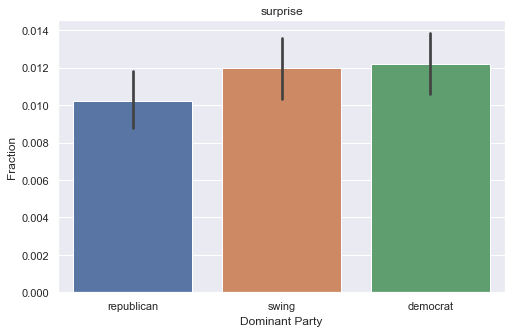

In [36]:
plotIndividualEmotion("surprise")

Similar: swing and democrat

### Disgust

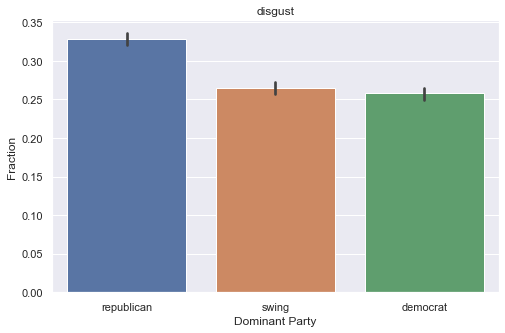

In [37]:
plotIndividualEmotion("disgust")

Similar: swing and democrat

### Others

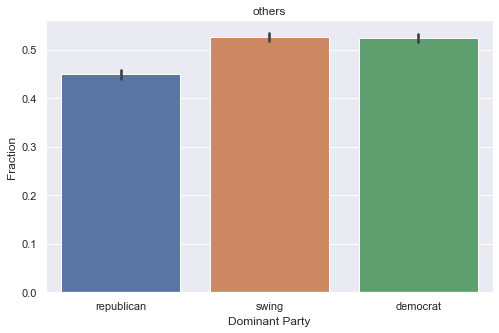

In [38]:
plotIndividualEmotion("others")

Similar: swing and democrat

## Analysis driven by the dominant emotion in individual tweets

In [39]:
# helper function
def assignEmotion(dataframe, emotions_columns):
    two_dominant_emotions = dataframe[emotions_columns].apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=2)
    return two_dominant_emotions

In [40]:
dominant_emotions_individual_tweets = assignEmotion(df, ["others",
                                                         "joy", 
                                                         "sadness", 
                                                         "fear", 
                                                         "surprise", 
                                                         "anger", 
                                                         "disgust"])

In [41]:
df = df.assign(dominant_emotion=dominant_emotions_individual_tweets[0])
df = df.assign(second_dominant_emotion=dominant_emotions_individual_tweets[1])

In [42]:
df.groupby("dominant_party")["dominant_emotion"].describe()

,count,unique,top,freq
dominant_party,,,,
democrat,10000,7,others,5394
republican,10000,7,others,4604
swing,10000,7,others,5424


## 5 most common emotions for all groups of states

The labels were assigned for each tweet in accordance with the emotions for which the likelihood had the higest score. These labels are analyzed in a state group scale (democrat / republican / swing)

In [43]:
for party in ["democrat", "republican", "swing"]:
    tuples = df[df.dominant_party == party]["dominant_emotion"]
    counter_e = Counter(tuples.ravel())
    print(f"[{party}]:\t{counter_e.most_common(5)}")
    # save to report
    with open(f"{storage_directory}/5_most_common_emotions.txt", "a") as fh:
        fh.write(f"[{party}]:\t{counter_e.most_common(5)}\n")

[democrat]:	[('others', 5394), ('disgust', 2637), ('joy', 985), ('anger', 665), ('fear', 115)]
[republican]:	[('others', 4604), ('disgust', 3391), ('anger', 927), ('joy', 811), ('sadness', 104)]
[swing]:	[('others', 5424), ('disgust', 2701), ('joy', 903), ('anger', 689), ('fear', 105)]


In [44]:
df.to_csv("data/with_dominant_emotion_label.csv")

## Summary

It seems that there is no drastic difference between the emotions intensities for the red / blue / swing states. All of the distributions have a similar shape - hill on the left for negative emotions, the biggest hill in the middle for neutral emotions and a slight hill on the right - for positive emotions. The difference is that in republican states, there were more negative emotions in tweets compared to democrat or swing states, and that in swing states there were more neutral emotions.

On average, the most negative intensity for emotions was recorded in states such as Hawaii, Vermont, Idaho and the most positive in states such as Delaware, New Mexico and Maryland. The analysis of standard deviations for the emotions intensities among states and then the analysis of the mean and mdian for these standard deviations have shown that the scatter in emotions is not skewed in any direction. The least deviation around the mean of emotions intensity was found in Vermont (std = 4.09) and the biggest in New Mexico (std = 6.5). Considering that the critical values for these intensities were -10 and 10, the standard deviation of between 4-6.5 can be considered quite high, indicating that the values were located not only close to the mean.

The most common emotion apart from others (or neutral) was disgust which was determined both at the *state-level* (cell number 20), as well as on the *dominant-party level* (cell number 40). 3 states had the most dominant emotion (apart from neutral) other than disgust, these were: Delware: joy, Maine: anger, New Mexico: joy.

For the emotions grouped by party dominance it was quite difficult to spot an indication of some evident tendency, apart from the mentioned results: slightly higer number for angry/disgusted attitudes in republican states and much more neutrality in the swing states and in the blue states than in the red states. In the context of individual emotions, similar pattern was found for swing and democrat states, however, apart from *anger*, *disgust* and *others* the dissimilarities were minor.

### Adjustment for the performance measure

Because the second most dominant emotion can be taken into account to evaluate model's performance, another column for the second dominant emotion predicted by the model is appened to the previous manual evaluation CSV file.

It allows for taking into account subjetivity of emotions understanding, which can be confusing even for people, not to mention a model.

In [75]:
performance_eval_df = pd.read_csv("qualitative_evaluation_emotions/qualitatively_analysed.csv")

In [76]:
performance_eval_df.drop(columns=["Unnamed: 0"], inplace=True)

In [77]:
performance_eval_df = performance_eval_df.set_index("Index")

In [79]:
new_performane_eval_df = pd.merge(performance_eval_df, df[["second_dominant_emotion"]], left_index=True, right_index=True)

In [82]:
new_performane_eval_df.columns = ["Tweet", "Model_label", "Qualitative_label", "Model_label2"]

In [84]:
new_performane_eval_df.to_csv("qualitative_evaluation_emotions/adjusted_qualitatively_analysed.csv")